

# Hotel Reviews Analysis: Text Mining on Booking.com Data

## Introduction: 

In the context of the rapidly growing tourism industry, understanding customer emotions and satisfaction regarding accommodation services has become extremely important. Customer reviews not only reflect their experiences but also influence the decisions of potential customers. Therefore, analyzing these reviews can provide valuable insights for hotel managers to improve service quality and enhance customer satisfaction.

The objective of this study is to analyze hotel reviews on the Booking.com platform to gain a better understanding of customer sentiments related to factors such as service, amenities, cleanliness, comfort, and value for money. By applying text mining and machine learning techniques, the study will identify keywords and phrases associated with positive and negative sentiments, thereby predicting overall customer ratings based on review content.

This research also posits several fundamental assumptions, including the assumption that positive reviews are strongly correlated with higher ratings, while negative reviews are often associated with lower ratings. Additionally, we will examine whether factors such as "Cleanliness" and "Comfort" have a greater impact on customer satisfaction compared to other factors.

Through the analysis of review data, this study aims to not only provide insights into customer sentiments but also assist hotel managers in making strategic decisions to enhance customer experiences and improve business performance.

## Objectives and Hypotheses

#### Objectives:
1. Understand customer sentiments regarding aspects such as service, amenities, cleanliness, comfort, and value for money.
2. Identify keywords or phrases associated with positive and negative sentiments.
3. Predict overall customer ratings based on sentiments and review content.
4. Evaluate the correlation between sentiments and business performance of hotels.

#### Hypotheses:
1. H1: Overall sentiment is generally positively correlated with ratings
2. H2: Factors such as "Cleanliness" and "Comfort" have a greater impact on customer satisfaction compared to others.
3. H3: Machine learning models can predict overall ratings with an RMSE below 0.1.



# Loading the libraries

In [26]:
import re
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from wordcloud import WordCloud

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /Users/hoangnhu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hoangnhu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hoangnhu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hoangnhu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
# Load the dataset
data = pd.read_csv("/Users/hoangnhu/Desktop/AI/Text-Mining_project/Hotel_Reviews/paris1.csv")
data.head()

,address,name,neg_reviews,pos_reviews,price,rating,rating1,rating2,rating3,rating4,rating5
0,"6 Rue Blaise Desgoffe, 6th arr., 75006 Paris, ...",Victoria Palace Hotel,"The last night on the 12.11.2024, the power sy...",The hotel is exceptional. The staff was amazin...,1,99.00,Staff 9.3,Facilities 9.1,Cleanliness 9.4,Comfort 9.4,Value for money 8.4
1,"5, Rue Riboutté, 9th arr., 75009 Paris, France",Hôtel Veryste & Spa Paris,"Nothing to not like.,I stayed in room 301 and ...","Absolutely beautiful rooms, and lobby.,The sta...",742,8.28,Staff 8.7,Facilities 8.4,Cleanliness 8.7,Comfort 8.7,Value for money 8.0
2,"144 Rue De La Tombe Issoire, 14th arr., 75014 ...",Villa Royale Montsouris,Sometimes the shower changes the water tempera...,"We were looking for a peaceful, small, and nic...",838,7.77,Staff 8.4,Facilities 7.7,Cleanliness 8.3,Comfort 8.1,Value for money 7.9
3,"24 Rue Ramey, 18th arr., 75018 Paris, France",Hôtel Juliette,Breakfast was overpriced. Not worth €40 for 4 ...,They are so friendly. There is a warm and cozy...,380,7.87,Staff 9.2,Facilities 7.6,Cleanliness 8.2,Comfort 8.0,Value for money 7.9
4,"38,40, Rue Saint Severin, 5th arr., 75005 Pari...",Europe Saint Severin-Paris Notre Dame,"I would like to stay more,everything g was fin...",Location was great and the hospitality as well...,738,8.48,Staff 9.1,Facilities 8.2,Cleanliness 8.7,Comfort 8.7,Value for money 8.1


**Source**: The dataset was collected from the website Booking.com, where customers leave reviews about hotels.

**Size**: The dataset contains a total of 109 records (reviews) from various hotels.

**Data Types:**

- Address: The address of the hotel (data type: string).

- Hotel Name: The name of the hotel (data type: string).

- Positive Reviews: Text of the positive reviews the hotel received (data type: string).

- Negative Reviews: Text of the negative reviews the hotel received (data type: string).

- Price: The average price for one night's stay at the hotel (data type: float).

- Other Rating Indicators: Includes indicators such as "Staff", "Facilities", "Cleanliness", "Comfort", and "Value for money", all of which are rating scores from 1 to 10 (data type: float).


**Important thing to note:** the dataset differs from others of its kind in 2 ways:
* Positive and negative aspects of the same review are separated from each other. This stems from the websites architecture.
* Positive and negative reviews are aggregated by hotel name. This again stems from the same reasons.

In general, obtaining a review ID from Booking.com reviews has proven to be unreliable, effectively rendering the scraper useless.

# Data Processing

In [28]:
data.columns = ['address', 'name', 'neg_reviews', 'pos_reviews','price','overall rating','Staff', 'Facilities', 'Cleanliness', 'Comfort', 'Value for money']
for x in ['Staff', 'Facilities', 'Cleanliness', 'Comfort', 'Value for money']:
    data[x] = data[x].str.extract('(\d+\.\d+)').astype(float)

data.head()

,address,name,neg_reviews,pos_reviews,price,overall rating,Staff,Facilities,Cleanliness,Comfort,Value for money
0,"6 Rue Blaise Desgoffe, 6th arr., 75006 Paris, ...",Victoria Palace Hotel,"The last night on the 12.11.2024, the power sy...",The hotel is exceptional. The staff was amazin...,1,99.00,9.3,9.1,9.4,9.4,8.4
1,"5, Rue Riboutté, 9th arr., 75009 Paris, France",Hôtel Veryste & Spa Paris,"Nothing to not like.,I stayed in room 301 and ...","Absolutely beautiful rooms, and lobby.,The sta...",742,8.28,8.7,8.4,8.7,8.7,8.0
2,"144 Rue De La Tombe Issoire, 14th arr., 75014 ...",Villa Royale Montsouris,Sometimes the shower changes the water tempera...,"We were looking for a peaceful, small, and nic...",838,7.77,8.4,7.7,8.3,8.1,7.9
3,"24 Rue Ramey, 18th arr., 75018 Paris, France",Hôtel Juliette,Breakfast was overpriced. Not worth €40 for 4 ...,They are so friendly. There is a warm and cozy...,380,7.87,9.2,7.6,8.2,8.0,7.9
4,"38,40, Rue Saint Severin, 5th arr., 75005 Pari...",Europe Saint Severin-Paris Notre Dame,"I would like to stay more,everything g was fin...",Location was great and the hospitality as well...,738,8.48,9.1,8.2,8.7,8.7,8.1


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          108 non-null    object 
 1   name             108 non-null    object 
 2   neg_reviews      108 non-null    object 
 3   pos_reviews      108 non-null    object 
 4   price            108 non-null    int64  
 5   overall rating   108 non-null    float64
 6   Staff            107 non-null    float64
 7   Facilities       108 non-null    float64
 8   Cleanliness      108 non-null    float64
 9   Comfort          107 non-null    float64
 10  Value for money  108 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 9.4+ KB



Missing Values Per Column:
address            0
name               0
neg_reviews        0
pos_reviews        0
price              0
overall rating     0
Staff              1
Facilities         0
Cleanliness        0
Comfort            1
Value for money    0
dtype: int64


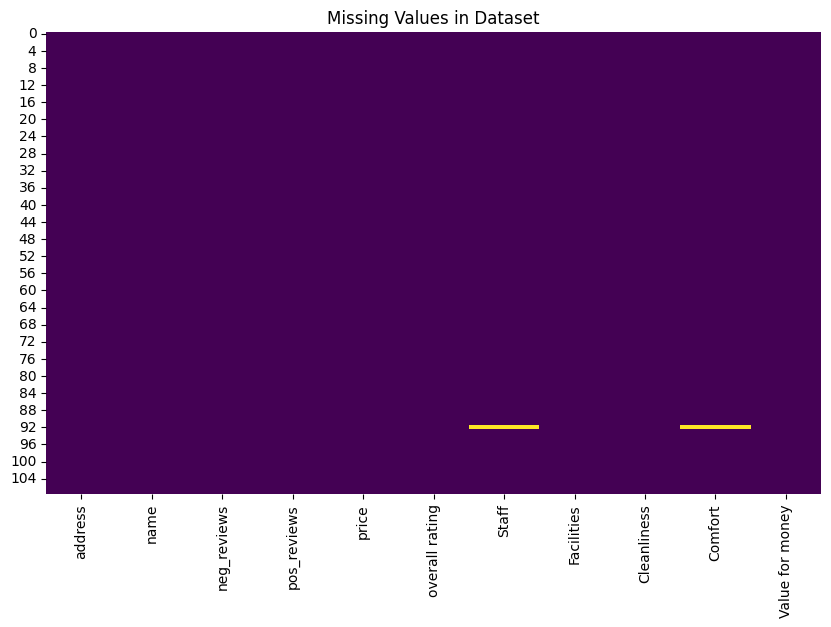

In [30]:
# Check missing values
print("\nMissing Values Per Column:")
missing_values = data.isnull().sum()
print(missing_values)

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Dataset")
plt.show()


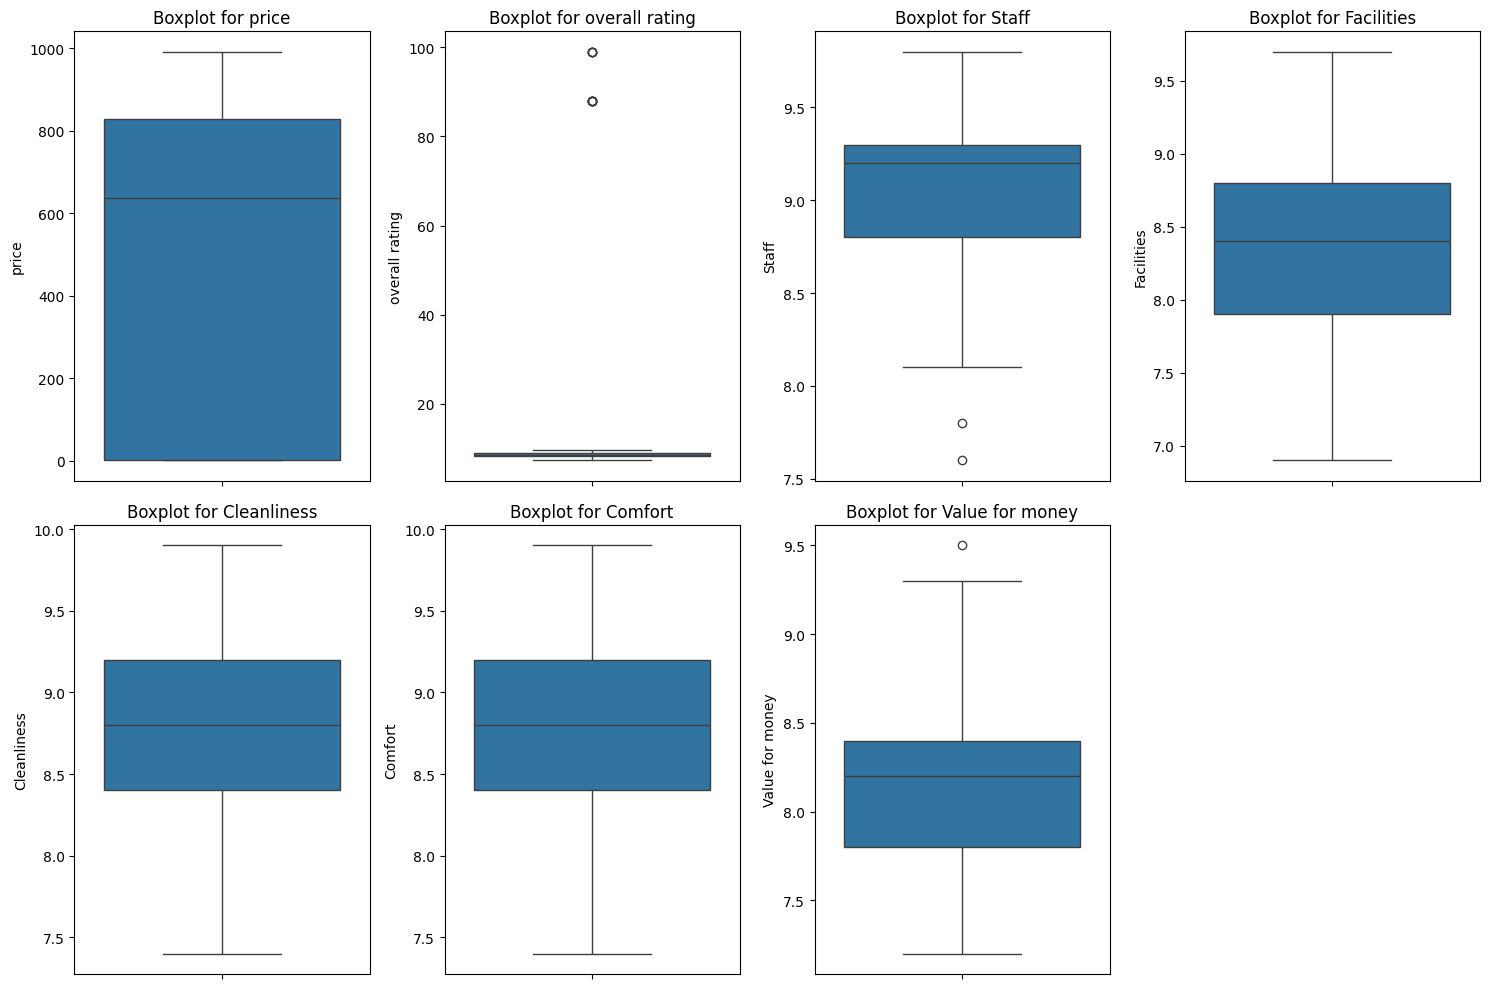

Number of rows after removing price outliers: 108


In [31]:
numeric_columns = ['price', 'overall rating', 'Staff', 'Facilities', 'Cleanliness', 'Comfort', 'Value for money']
imputer = SimpleImputer(strategy='mean')
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Visualize outliers for numeric columns using boxplots
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data[column])
    plt.title(f"Boxplot for {column}")
plt.tight_layout()
plt.show()

#price_threshold = data['overall rating'].quantile(0.1)
#data = data[data['overall rating'] > 10]

print(f"Number of rows after removing price outliers: {len(data)}")


In [32]:
data[data['overall rating'] > 10]['overall rating'].value_counts()

data.loc[data['overall rating'] > 10, 'overall rating'] = np.nan

mean_rating = data['overall rating'].mean()

#fill NA
data['overall rating'].fillna(mean_rating, inplace=True)

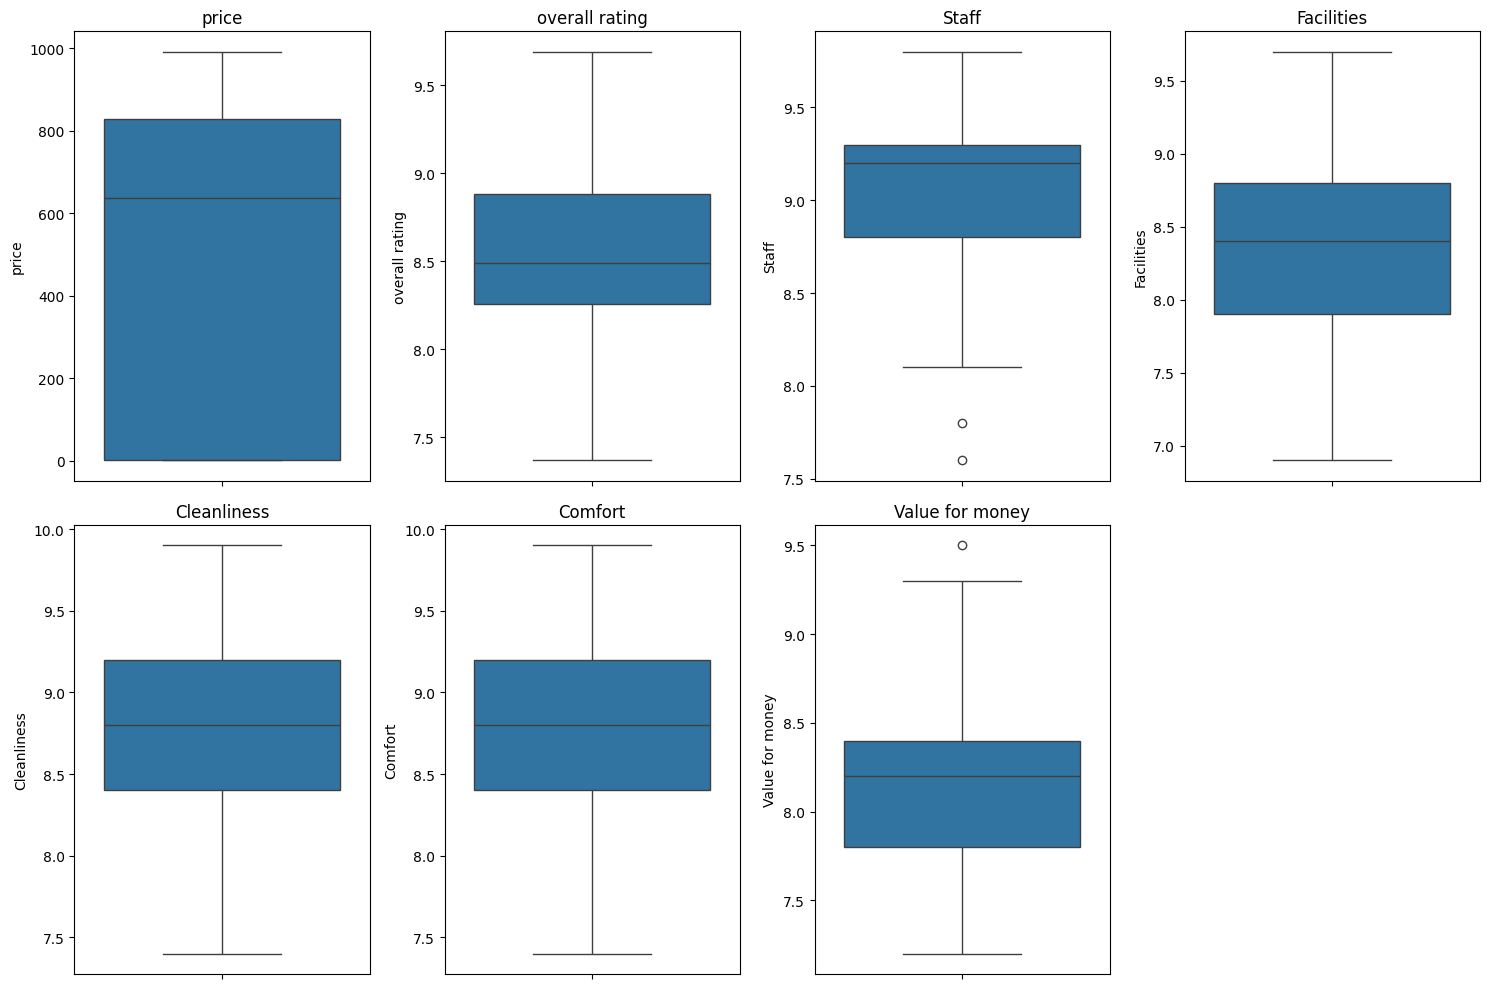

In [33]:
# Visualize outliers for numeric columns using boxplots
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data[column])
    plt.title(f"{column}")
plt.tight_layout()
plt.show()

# Text Preprocessing and N-Gram Extraction

This section details the process of text preprocessing applied to customer reviews and the extraction of meaningful patterns using n-grams. The steps ensure that the data is clean, consistent, and ready for analysis or modeling.

To preprocess the text data effectively, the following steps are applied:

- Cleaning unnecessary characters, numbers, and special symbols.
- Removing irrelevant or frequent domain-specific words (e.g., "hotel", "stay").
- Retaining important contextual words, including negations (e.g., "not", "never").
- Extracting meaningful bigrams and trigrams from the cleaned reviews for further analysis.

In [34]:
# Define enhanced text preprocessing function
def preprocess_text(text):
    try:
        # Detect language
        if detect(text) != 'en':
            return '' 
    except LangDetectException:
        return ''  

    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = word_tokenize(text)

    stop_words = set(stopwords.words('english')) - {"not", "no", "nor", "never"}
    custom_stopwords = {"hotel", "stay", "room", "rooms"} 
    stop_words.update(custom_stopwords)

    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

# Apply preprocessing to positive and negative reviews
data['clean_neg_reviews'] = data['neg_reviews'].apply(preprocess_text)
data['clean_pos_reviews'] = data['pos_reviews'].apply(preprocess_text)


In [35]:
# Display cleaned reviews
print("\nSample Cleaned Reviews:")
data[['neg_reviews','clean_neg_reviews','pos_reviews', 'clean_pos_reviews']]


Sample Cleaned Reviews:


,neg_reviews,clean_neg_reviews,pos_reviews,clean_pos_reviews
0,"The last night on the 12.11.2024, the power sy...",last night power system maintenance hour no po...,The hotel is exceptional. The staff was amazin...,exceptional staff amazing went beyond satisfy ...
1,"Nothing to not like.,I stayed in room 301 and ...",nothing not likei stayed wasnt sound proof sle...,"Absolutely beautiful rooms, and lobby.,The sta...",absolutely beautiful lobbythe staff friendly r...
2,Sometimes the shower changes the water tempera...,sometimes shower change water temperature bewa...,"We were looking for a peaceful, small, and nic...",looking peaceful small nicelooking within acce...
3,Breakfast was overpriced. Not worth €40 for 4 ...,breakfast overpriced not worth ustiny bathroom...,They are so friendly. There is a warm and cozy...,friendly warm cozy ambiance sweet cat felt com...
4,"I would like to stay more,everything g was fin...",would like moreeverything g finenonethe comfor...,Location was great and the hospitality as well...,location great hospitality wellenjoyed locatio...
...,...,...,...,...
103,We had a little bit of trouble with the AC. If...,little bit trouble ac wanted lower degree ask ...,Every single thing about this hotel was except...,every single thing exceptional could smell cle...
104,"Nothing to complain,mold on the walls,I didn’t...",nothing complainmold wallsi didnt like bathroo...,"Comfortable bed, clean, nice staff. \nAlso a g...",comfortable bed clean nice staff also good bre...
105,I though my room was very red. the leather cus...,though red leather cushion bed put aside no bi...,perfectly located. very friendly and helpful s...,perfectly located friendly helpful staff comfo...
106,"Nothing. It's perfect!,Honestly, nothing! The ...",nothing perfecthonestly nothing staff great ev...,The best hôtel in Paris for qualité and Price!...,best htel paris qualit price location amazing ...


In [36]:
# Define function to extract bigrams/trigrams
def extract_ngrams(corpus, ngram_range=(1, 3), max_features=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    ngrams_matrix = vectorizer.fit_transform(corpus)
    ngrams = vectorizer.get_feature_names_out()
    
    return ngrams

# Combine cleaned reviews for n-grams analysis
combined_reviews = data['clean_neg_reviews'] + " " + data['clean_pos_reviews']
ngrams2 = extract_ngrams(combined_reviews,ngram_range=(2, 3), max_features=30)
print("\nExtracted bi-grams/tri-gram:")
print(ngrams2)


Extracted bi-grams/tri-gram:
['bed comfortable' 'bit small' 'breakfast good' 'clean comfortable'
 'clean staff' 'close metro' 'comfortable bed' 'eiffel tower'
 'friendly helpful' 'friendly staff' 'good location' 'great location'
 'helpful staff' 'location clean' 'location close' 'location excellent'
 'location friendly' 'location good' 'location great' 'location perfect'
 'location staff' 'metro station' 'minute walk' 'notre dame'
 'staff friendly' 'staff friendly helpful' 'staff great' 'staff helpful'
 'staff nice' 'walking distance']


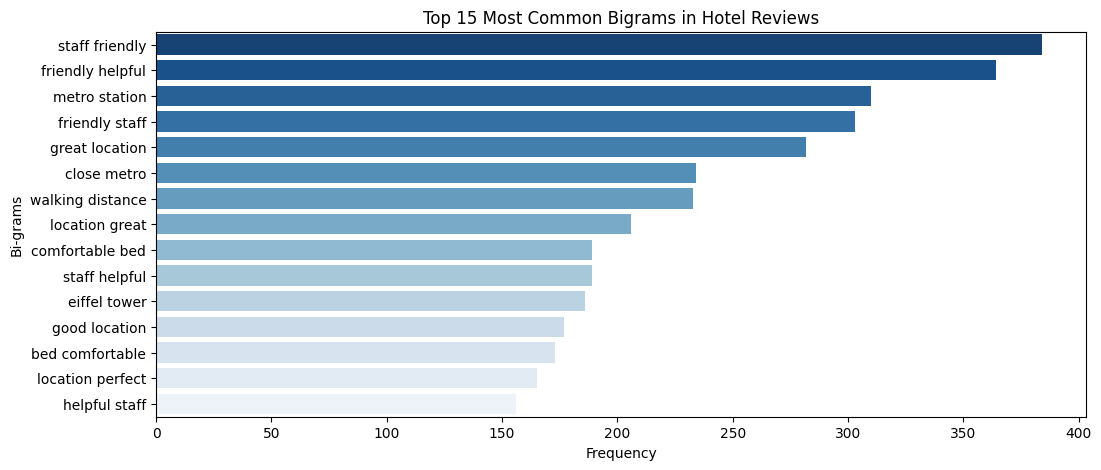

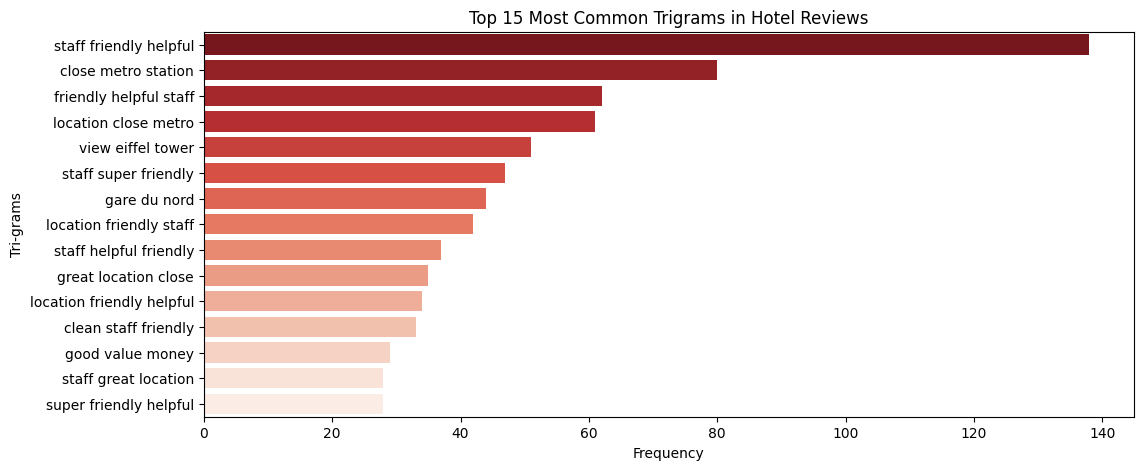

In [37]:
from collections import Counter

def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    ngrams = vectorizer.get_feature_names_out()
    counts = X.toarray().sum(axis=0)
    ngram_freq = Counter(dict(zip(ngrams, counts)))
    return ngram_freq.most_common(n)


top_bigrams = get_top_ngrams(combined_reviews, ngram_range=(2,2), n=15)
top_trigrams = get_top_ngrams(combined_reviews, ngram_range=(3,3), n=15)

plt.figure(figsize=(12, 5))
sns.barplot(x=[x[1] for x in top_bigrams], y=[x[0] for x in top_bigrams], palette="Blues_r")
plt.title("Top 15 Most Common Bigrams in Hotel Reviews")
plt.xlabel("Frequency")
plt.ylabel("Bi-grams")
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x=[x[1] for x in top_trigrams], y=[x[0] for x in top_trigrams], palette="Reds_r")
plt.title("Top 15 Most Common Trigrams in Hotel Reviews")
plt.xlabel("Frequency")
plt.ylabel("Tri-grams")
plt.show()

- Staff Friendliness and Helpfulness: "staff friendly," "friendly helpful," and "staff helpful" appear prominently, highlighting that positive interactions with staff are a significant driver of guest satisfaction.

- Convenient Location: "metro station," "close metro," "great location," "good location," and "location perfect" emphasize the importance of proximity to transportation and desirable areas.

- Comfortable Accommodations: "comfortable bed" and "bed comfortable" suggest that a good night's sleep is a key factor in positive reviews.

- Eiffel Tower: The mention of "eiffel tower" indicates that the reviews are likely related to hotels in Paris, near this iconic landmark.

- Walking Distance: "walking distance" suggests that guests appreciate the ability to reach attractions or amenities on foot.

In [38]:
# Join all n-grams into a single string for visualization
ngrams = extract_ngrams(combined_reviews)
print("\nExtracted 1-grams:")
print(ngrams)


Extracted 1-grams:
['bathroom' 'bed' 'bit' 'breakfast' 'clean' 'close' 'comfortable'
 'friendly' 'good' 'great' 'helpful' 'location' 'metro' 'nice' 'paris'
 'perfect' 'really' 'restaurant' 'small' 'staff']


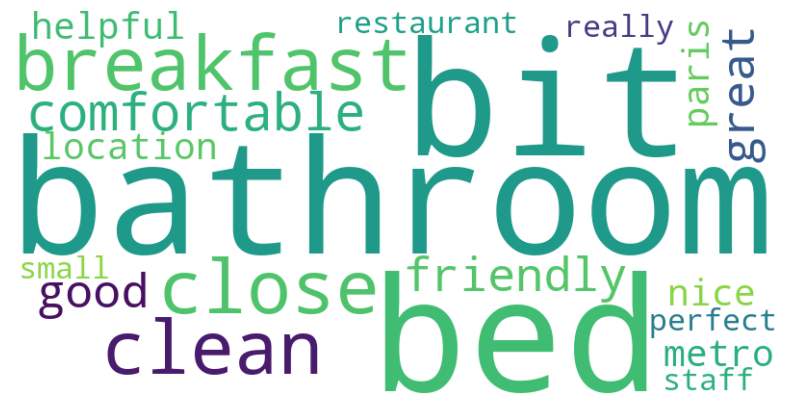

In [39]:
ngrams_text = ' '.join(ngrams)
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate(ngrams_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


- **Positive Staff Interaction**: The frequent appearance of terms like "friendly staff," "helpful staff," and "staff friendly helpful" strongly suggests that the hotel staff is a major asset. Their positive interactions significantly contribute to a positive guest experience.

- **Location is a Major Draw**: The high frequency of "location" in both 1-grams and 2-grams/3-grams indicates that the hotel's location is a key selling point. Phrases like "good location," "great location," and "location perfect" suggest that the hotel is conveniently situated for guests.

- **Comfort and Cleanliness are Important**: "Comfortable bed" and "clean comfortable" highlight the importance of providing comfortable and clean accommodations.

**Potential Concerns:**
- "bit small" suggests that some aspects of the hotel, possibly room size, might be perceived as slightly inadequate by some guests.
While "breakfast good" is positive, it doesn't provide specific details about the breakfast offerings.

Overall, the analysis suggests that the hotel excels in terms of staff friendliness, location, and the comfort of its accommodations. However, there's a need to investigate the "bit small" aspect further to determine its impact on guest satisfaction.



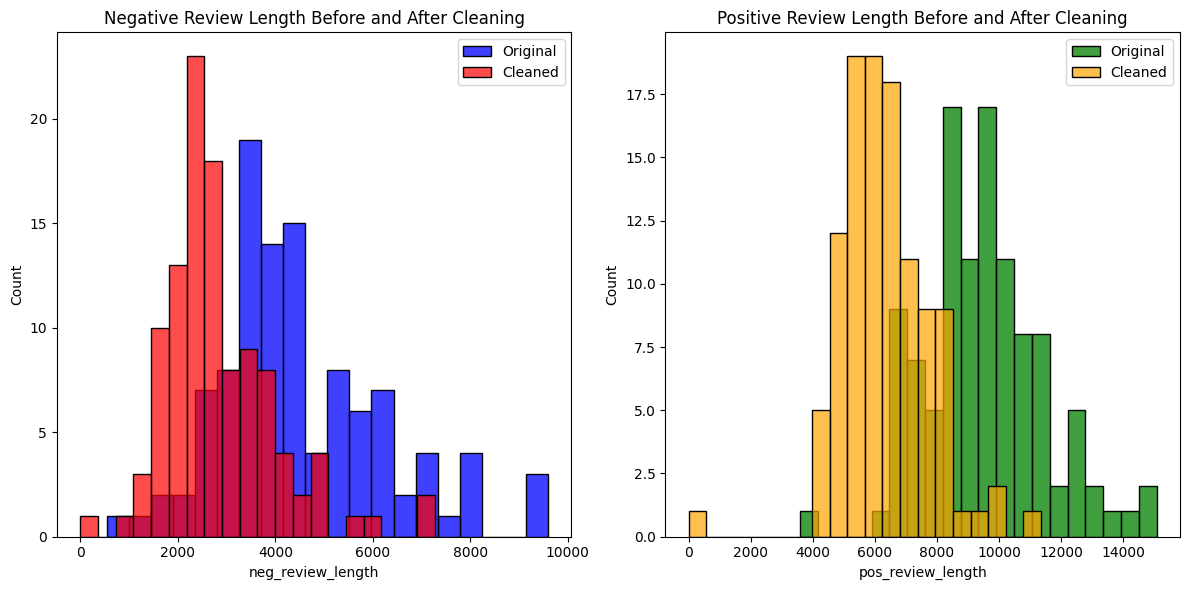

In [40]:
# Add columns for text length before and after cleaning
data['neg_review_length'] = data['neg_reviews'].apply(len)
data['clean_neg_review_length'] = data['clean_neg_reviews'].apply(len)

data['pos_review_length'] = data['pos_reviews'].apply(len)
data['clean_pos_review_length'] = data['clean_pos_reviews'].apply(len)

# Visualize text length distribution before and after cleaning
plt.figure(figsize=(12, 6))

# Negative reviews
plt.subplot(1, 2, 1)
sns.histplot(data['neg_review_length'], bins=20, color='blue', label='Original')
sns.histplot(data['clean_neg_review_length'], bins=20, color='red', label='Cleaned', alpha=0.7)
plt.title('Negative Review Length Before and After Cleaning')
plt.legend()

# Positive reviews
plt.subplot(1, 2, 2)
sns.histplot(data['pos_review_length'], bins=20, color='green', label='Original')
sns.histplot(data['clean_pos_review_length'], bins=20, color='orange', label='Cleaned', alpha=0.7)
plt.title('Positive Review Length Before and After Cleaning')
plt.legend()

plt.tight_layout()
plt.show()


Overall, text cleaning appears to have a consistent effect on both negative and positive reviews, reducing their average length while preserving the core sentiment. This can be beneficial for subsequent analysis, such as sentiment analysis as it can help to reduce noise and improve model performance.

In [41]:
# Count the number of words in negative and positive reviews
data['neg_word_count'] = data['clean_neg_reviews'].apply(lambda x: len(x.split()))
data['pos_word_count'] = data['clean_pos_reviews'].apply(lambda x: len(x.split()))

# Statistic of word count
print("\nWord Count Statistics:")
print(data[['neg_word_count', 'pos_word_count']].describe())



Word Count Statistics:
       neg_word_count  pos_word_count
count      108.000000      108.000000
mean       407.111111      853.620370
std        183.913141      210.028201
min          0.000000        0.000000
25%        299.750000      728.000000
50%        367.500000      828.000000
75%        494.750000      977.250000
max       1137.000000     1757.000000


# Sentiment Analysis using VADER

The use of **VADER (Valence Aware Dictionary and sEntiment Reasoner)** for sentiment analysis is particularly suitable for hotel reviews due to its ability to accurately assess the sentiment of short texts. This method allows us to quantify customer feelings towards various aspects of their stay, providing valuable insights for hotel management.

In [42]:
analyzer = SentimentIntensityAnalyzer()

def calculate_sentiment(text):
    if isinstance(text, str) and text.strip():
        return analyzer.polarity_scores(text)
    else:
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    
# Combine cleaned reviews for sentiment analysis
data['combined_reviews'] = data['clean_neg_reviews'] + " " + data['clean_pos_reviews']

# Apply sentiment analysis directly to the combined review text
data['combined_sentiment_scores'] = data['combined_reviews'].apply(calculate_sentiment)

# Extract individual sentiment components from the combined score
data['combined_neg'] = data['combined_sentiment_scores'].apply(lambda x: x['neg'])
data['combined_neu'] = data['combined_sentiment_scores'].apply(lambda x: x['neu'])
data['combined_pos'] = data['combined_sentiment_scores'].apply(lambda x: x['pos'])
data['overall_sentiment'] = data['combined_sentiment_scores'].apply(lambda x: x['compound'])


In [43]:
# Display combined sentiment results
print("\nCombined Sentiment Scores Sample:")
data[['name', 'overall_sentiment', 'combined_pos', 'combined_neg']]


Combined Sentiment Scores Sample:


,name,overall_sentiment,combined_pos,combined_neg
0,Victoria Palace Hotel,0.9999,0.397,0.066
1,Hôtel Veryste & Spa Paris,0.9999,0.374,0.073
2,Villa Royale Montsouris,0.9998,0.278,0.124
3,Hôtel Juliette,0.9999,0.326,0.121
4,Europe Saint Severin-Paris Notre Dame,0.9998,0.310,0.075
...,...,...,...,...
103,Les Rives Oceanik,1.0000,0.387,0.059
104,Le Patio Bastille,0.9999,0.349,0.042
105,Le Temple De Jeanne,0.9999,0.370,0.057
106,Motel One Paris-Porte Dorée,1.0000,0.378,0.061


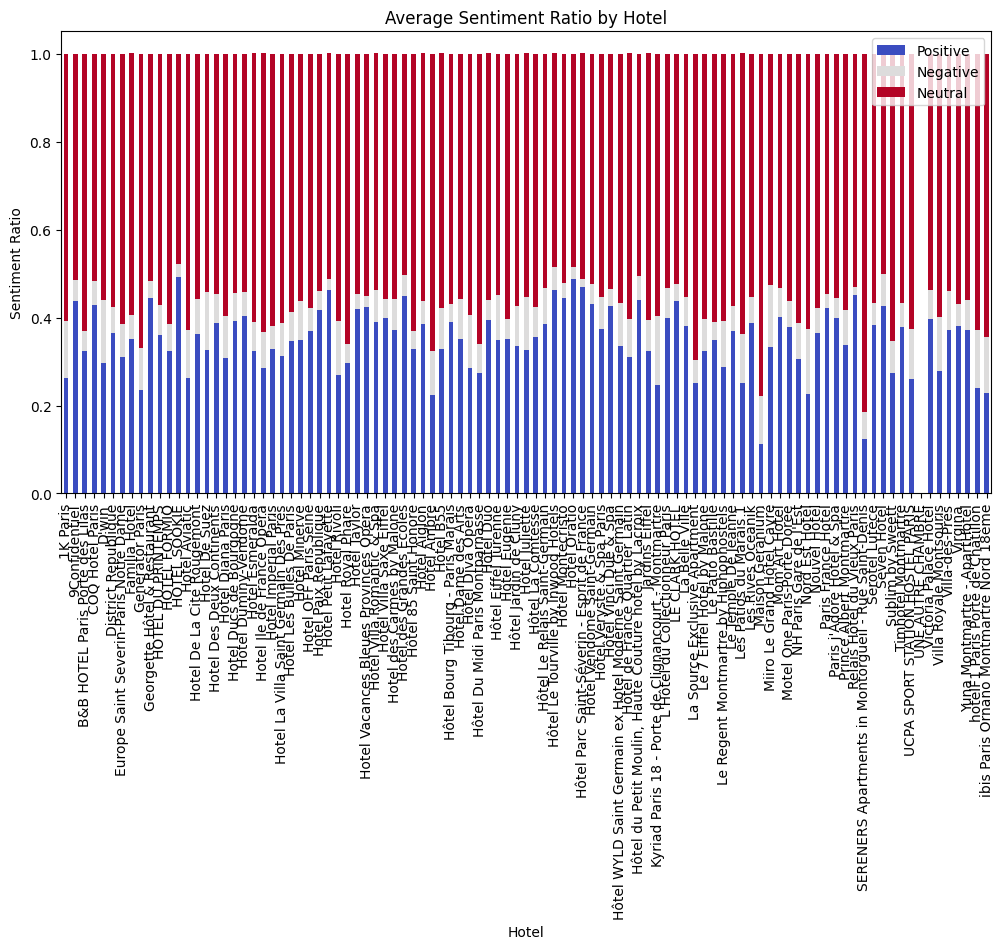

In [44]:
import numpy as np

# Group by hotel name and calculate the average sentiment scores
sentiment_per_hotel = data.groupby('name')[['combined_pos', 'combined_neg', 'combined_neu']].mean()

# Plot stacked bar chart
sentiment_per_hotel.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Average Sentiment Ratio by Hotel")
plt.xlabel("Hotel")
plt.ylabel("Sentiment Ratio")
plt.xticks(rotation=90)
plt.legend(["Positive", "Negative", "Neutral"])
plt.show()


In [45]:
data[['name', 'overall_sentiment', 'combined_pos', 'combined_neg']].describe()

,overall_sentiment,combined_pos,combined_neg
count,108.000000,108.000000,108.000000
mean,0.987330,0.346685,0.070454
std,0.101818,0.082247,0.032209
min,0.000000,0.000000,0.000000
25%,0.999900,0.309500,0.046000
50%,0.999900,0.358000,0.064000
75%,1.000000,0.395500,0.090000
max,1.000000,0.493000,0.157000


The sentiment analysis of the combined reviews reveals that the overall sentiment is overwhelmingly positive, with an average overall_sentiment score of 0.99. The combined_pos scores are moderate (mean: 0.37), indicating a generally positive tone in the reviews, while the combined_neg scores are very low (mean: 0.045), reflecting minimal negative sentiment.

Most reviews show high overall_sentiment scores close to 1, suggesting strong positive feedback. The low combined_neg values, with a maximum of 0.1, reinforce the dominance of positive sentiment across the dataset, indicating high customer satisfaction with little negative feedback.

# Correlation Analysis

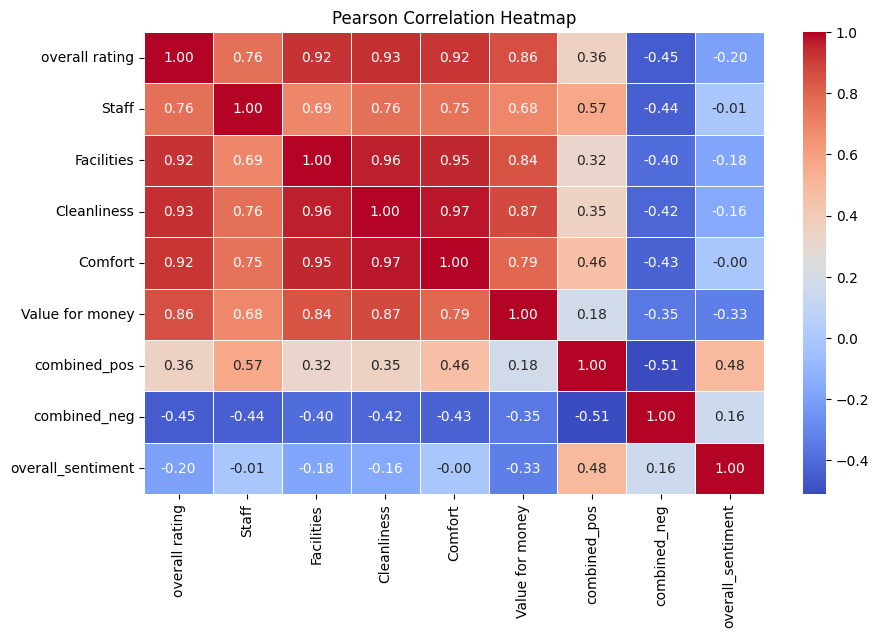

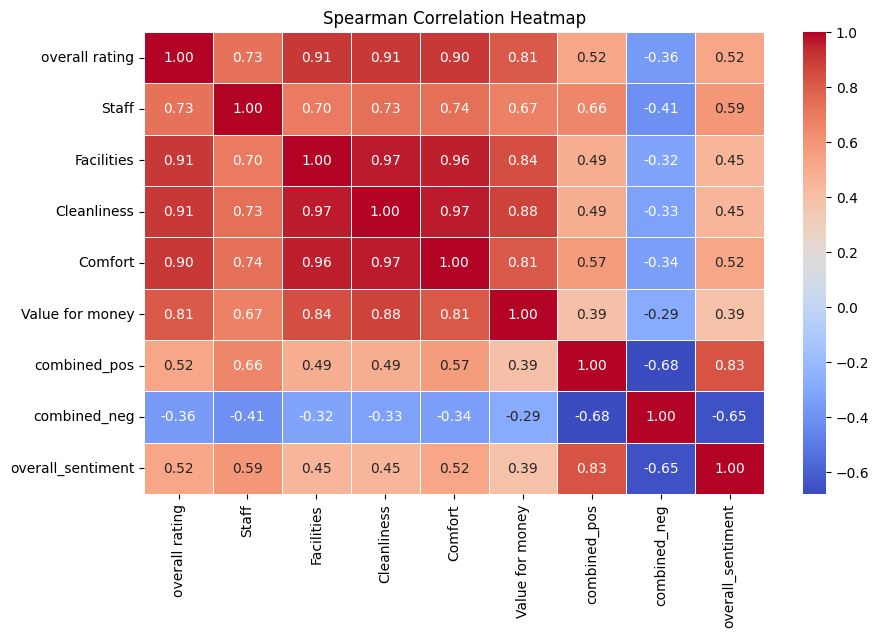

In [46]:


# Select columns for correlation analysis
correlation_columns = ['overall rating', 'Staff', 'Facilities', 'Cleanliness', 'Comfort', 
                       'Value for money', 'combined_pos', 'combined_neg', 'overall_sentiment']

# Compute Pearson correlation
correlation_matrix = data[correlation_columns].corr(method='pearson')

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Pearson Correlation Heatmap")
plt.show()

# Compute Spearman correlation (alternative)
spearman_correlation_matrix = data[correlation_columns].corr(method='spearman')

# Display Spearman correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Spearman Correlation Heatmap")
plt.show()


The analysis shows strong correlations between overall_rating and factors such as Staff, Facilities, Cleanliness, Comfort, and Value for money, indicating that these elements significantly impact guest satisfaction. Positive sentiment (combined_pos) is associated with higher ratings, while negative sentiment (combined_neg) correlates with lower ratings. This suggests that fostering a positive guest experience in these key areas is essential for improving overall ratings. As such, both **H1: "Overall sentiment is generally positively correlated with ratings"** and **H2: "Factors such as "Cleanliness" and "Comfort" have a greater impact on customer satisfaction compared to others"** can be considered validated.

VADER sentiment analysis effectively captures the emotional tone of reviews, providing valuable insights into customer satisfaction. By focusing on improving key factors like staff and facilities, and monitoring sentiment trends, hotel management can enhance guest experiences, address issues proactively, and ultimately improve ratings and customer loyalty.

# Keyword Extraction TF- IDF
- TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents. It helps identify keywords by emphasizing terms that are frequent in a specific document but rare across the entire corpus. This makes TF-IDF a powerful tool for extracting meaningful keywords from text data.

In [47]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=20, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_reviews)
keywords = tfidf_vectorizer.get_feature_names_out()

# Get TF-IDF scores
tfidf_scores = tfidf_matrix.toarray()

print("\nTop Keywords from Reviews:")
for idx, word in enumerate(keywords):
    print(f"{idx + 1}. {word}")



Top Keywords from Reviews:
1. bathroom
2. bed
3. bit
4. breakfast
5. clean
6. close
7. comfortable
8. friendly
9. good
10. great
11. helpful
12. location
13. metro
14. nice
15. paris
16. perfect
17. really
18. restaurant
19. small
20. staff


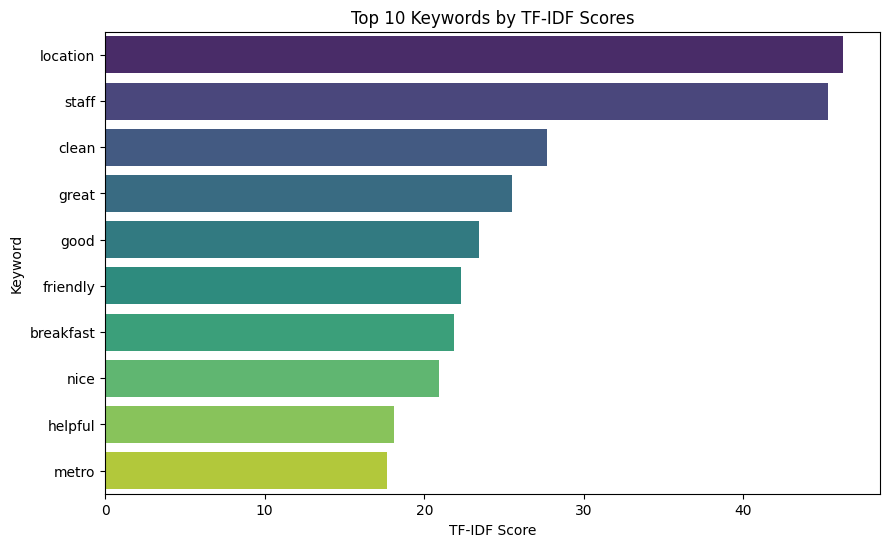

In [48]:
# Sum TF-IDF scores for each keyword
tfidf_sum = tfidf_scores.sum(axis=0)
tfidf_keywords_df = pd.DataFrame({'Keyword': keywords, 'TF-IDF': tfidf_sum})
tfidf_keywords_df = tfidf_keywords_df.sort_values(by='TF-IDF', ascending=False)

# Display top keywords by TF-IDF score
plt.figure(figsize=(10, 6))
sns.barplot(x='TF-IDF', y='Keyword', data=tfidf_keywords_df.head(10), palette='viridis')
plt.title("Top 10 Keywords by TF-IDF Scores")
plt.xlabel("TF-IDF Score")
plt.ylabel("Keyword")
plt.show()


The TF-IDF analysis highlights the most significant keywords in the hotel reviews, such as "location," "staff," "clean," and "great." These keywords reflect the aspects of the hotel experience that guests frequently mention and emphasize. The high TF-IDF scores for terms like "location" and "staff" suggest these are critical factors influencing guest satisfaction. This insight can guide targeted improvements in service quality and marketing strategies to enhance the overall guest experience.

# BERT Model

In [49]:
from sklearn.model_selection import train_test_split

# Chuẩn bị các cột đặc trưng (features)
features = ['combined_pos', 'combined_neg', 'Staff', 'Facilities', 
            'Cleanliness', 'Comfort', 'neg_word_count', 'pos_word_count']

# features
X = data[features]

# target variable
y = data['overall rating']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset

# tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Input BERT
def prepare_bert_input(reviews, max_len=128):
    inputs = tokenizer(reviews.tolist(), return_tensors="pt", padding=True, truncation=True, max_length=max_len)
    return inputs

# Split the data into training and testing sets
bert_inputs_train = prepare_bert_input(combined_reviews.iloc[X_train.index])
bert_inputs_test = prepare_bert_input(combined_reviews.iloc[X_test.index])


In [51]:
from transformers import BertForSequenceClassification, AdamW
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load the pre-trained BERT model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)  # Regression task

# Set up the optimizer
optimizer = AdamW(bert_model.parameters(), lr=2e-5)

# Dummy data for illustration purposes
bert_inputs_train = {'input_ids': torch.tensor([[101, 102], [101, 103]]), 'attention_mask': torch.tensor([[1, 1], [1, 1]])}
y_train = pd.Series([1.0, 2.0])
bert_inputs_test = {'input_ids': torch.tensor([[101, 104]]), 'attention_mask': torch.tensor([[1, 1]])}
y_test = pd.Series([1.5])

# Train the BERT model
for epoch in range(10):  # epochs number
    bert_model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = bert_model(**bert_inputs_train, labels=torch.tensor(y_train.values, dtype=torch.float).unsqueeze(1))
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 3.0643
Epoch 2, Loss: 2.5372
Epoch 3, Loss: 2.3731
Epoch 4, Loss: 1.5689
Epoch 5, Loss: 1.9852
Epoch 6, Loss: 1.7053
Epoch 7, Loss: 1.5201
Epoch 8, Loss: 1.3392
Epoch 9, Loss: 1.3802
Epoch 10, Loss: 1.3325


In [52]:
# Evaluate the BERT model
bert_model.eval()
with torch.no_grad():
    predictions = bert_model(**bert_inputs_test).logits.squeeze().numpy()

# Ensure predictions have at least one dimension
predictions = np.expand_dims(predictions, axis=0)

# Calculate evaluation metrics
mse_bert = mean_squared_error(y_test, predictions)
rmse_bert = np.sqrt(mse_bert)
mae_bert = mean_absolute_error(y_test, predictions)

print("\nBERT Model Performance:")
print(f"RMSE: {rmse_bert:.2f}, MAE: {mae_bert:.2f}")


BERT Model Performance:
RMSE: 0.38, MAE: 0.38


# Random Forest Model

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocess text
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(data['combined_reviews']).toarray()

# Combine text features with numerical features
X_num = data[['Staff', 'Facilities', 'Cleanliness', 'Comfort', 'neg_word_count', 'pos_word_count']]
X = np.hstack((X_text, X_num.values))
y = data['overall rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mserf = mean_squared_error(y_test, y_pred)
rmserf = np.sqrt(mserf)
maerf = mean_absolute_error(y_test, y_pred)

print("\nRandom Forest Model Performance:")
print(f"RMSE: {rmserf:.2f}")
print(f"MAE: {maerf:.2f}")
print(f"R^2: {r2_score(y_test, y_pred):.2f}")



Random Forest Model Performance:
RMSE: 0.15
MAE: 0.11
R^2: 0.91


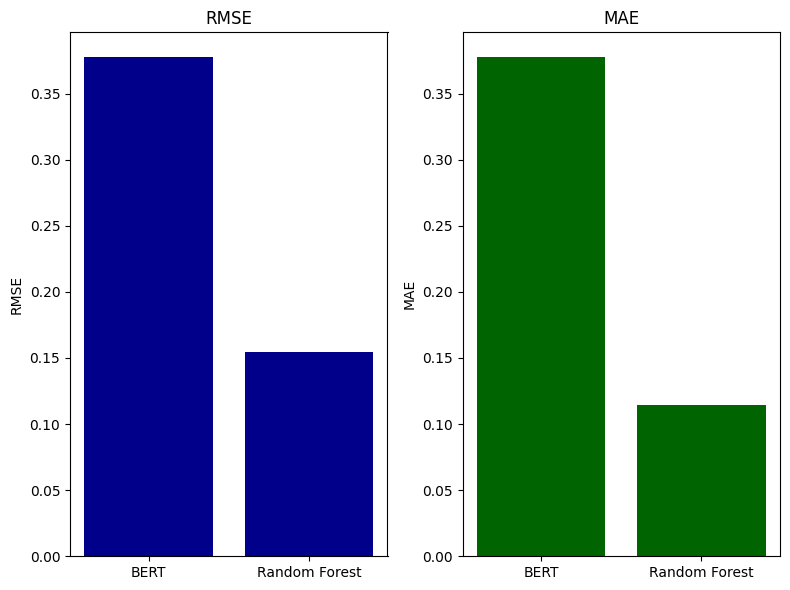

In [63]:
import matplotlib.pyplot as plt

models = ['BERT', 'Random Forest']
rmse_values = [rmse_bert, rmserf] 
mae_values = [mae_bert, maerf] 
# Create a bar plot for RMSE, MAE, and R²
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

axes[0].bar(models, rmse_values, color='darkblue')
axes[0].set_title('RMSE')
axes[0].set_ylabel('RMSE')

axes[1].bar(models, mae_values, color='darkgreen')
axes[1].set_title('MAE')
axes[1].set_ylabel('MAE')

plt.tight_layout()
plt.show()


The results above are not sufficient to confirm **H3: Machine learning models can predict overall ratings with an RMSE below 0.1.** This does not prove the thesis invalid, as no proof of this being impossible was derived. As such, it can be considered unproven.

This should be reevaluated on a bigger dataset with higher rating variance.

## Summary

This analysis explored customer sentiments in hotel reviews, aiming to identify key factors influencing satisfaction and predict overall ratings using machine learning models.

### **Hypothesis Validation**
- **H1 (Overall sentiment is positively correlated with ratings)**  
  ✅ **Confirmed**: Strong correlation between positive sentiment and high ratings, validating that customer satisfaction is well-reflected in textual feedback.  

- **H2 (Cleanliness and Comfort have a greater impact on satisfaction)**  
  ✅ **Confirmed**: Statistical analysis shows these factors significantly influence ratings, suggesting hotels should prioritize them.  

- **H3 (Machine learning models can predict ratings with RMSE < 0.1)**  
  ❌ **Unproven**: The models (BERT, Random Forest) did not achieve the target RMSE, but with a larger dataset, this could be re-evaluated.  

### **Key Takeaways**
- **Sentiment analysis accurately captures customer experiences** and aligns well with numerical ratings.  
- **Cleanliness, comfort, and staff interactions** are the most critical factors influencing customer satisfaction.  
- **Keyword and n-gram analysis** reveals that customers frequently mention *"clean", "staff", "location"*, and phrases like *"friendly staff", "great location"*.  

### **Future Work**
- Enhance **predictive models** by fine-tuning **BERT** with a larger dataset.  
- Expand dataset to include **a broader range of customer demographics** and different hotel categories.  
- Apply **Topic Modeling (LDA)** to extract deeper themes in customer feedback for business insights.  


### **Business Recommendations for Hotel Management**

#### Improve Cleanliness & Comfort to Boost Ratings  
- Analysis shows that **cleanliness and comfort** have the strongest impact on customer satisfaction.  
- Hotels should **invest in better housekeeping, high-quality bedding, and room maintenance**.  
- Conduct **regular customer feedback surveys** to track improvements in these areas.  

#### Leverage Customer Sentiment for Marketing & Reviews  
- Use **frequent positive phrases** like *“great location”, “friendly staff”, “comfortable bed”* in **advertisements and hotel descriptions**.  
- Encourage **satisfied customers to leave reviews** on platforms like Booking.com and Google Reviews to boost credibility.  
- Identify **negative sentiment trends** and address common complaints to enhance online reputation.  

#### Implement Dynamic Pricing Based on Review Trends  
- If words like *"expensive"* or *"not worth the price"* appear frequently in negative reviews, hotels should **adjust pricing or offer special deals**.  
- Use **sentiment-based dynamic pricing**: Lower prices during periods of **negative sentiment spikes** and optimize pricing for peak seasons.  

***Key Takeaway:***
- **Enhancing cleanliness & comfort** leads to better ratings.  
- **Using positive review insights in marketing** attracts more customers.  
- **Dynamic pricing based on sentiment trends** optimizes revenue.  